<a href="https://colab.research.google.com/github/mrdostory/OpenSource_Project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Google Drive 연동

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import modules
import os
import torch
import torchvision
from torch import nn
import numpy as np
import torch.backends.cudnn as cudnn
cudnn.benchmark = True

import math
import matplotlib.pyplot as plt
import torch.nn.functional as F
from model import *
from tqdm import tqdm as tqdm
import pickle
from copy import deepcopy
import warnings
warnings.filterwarnings("ignore", category=UserWarning) # get rid of interpolation warning
import kornia.filters as k
from torchvision.utils import save_image
from util import *
import scipy

from torch import optim
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

import lpips
from model import Generator
import numpy as np
from util import *

os.environ['KMP_DUPLICATE_LIB_OK']='True'

from google.colab import output
output.enable_custom_widget_manager()
from object_detection.utils import colab_utils
%matplotlib inline


In [ ]:
# models 모듈 설치
!git clone https://github.com/mchong6/SOAT.git
%cd SOAT
!pip install tqdm gdown scikit-learn scipy lpips opencv-python kornia
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'SOAT'...
remote: Enumerating objects: 206, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 206 (delta 27), reused 26 (delta 26), pack-reused 176
Receiving objects: 100% (206/206), 71.16 MiB | 15.28 MiB/s, done.
Resolving deltas: 100% (64/64), done.
/content/SOAT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 551 kB 20.9 MB/s 
Cloning into 'models'...
remote: Enumerating objects: 3578, done.
remote: Counting objects: 100% (3578/3578), done.
remote: Compressing objects: 100% (2980/2980), done.
remote: Total 3578 (delta 941), reused 1512 (delta 544), pack-reused 0
Receiving objects: 100% (3578/3578), 47.07 MiB | 14.68 MiB/s, done.
Resolving deltas: 100% (941/941), done.


In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install -q .

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


In [ ]:
#@title imports

import os
import torch
import torchvision
from torch import nn
import numpy as np
import torch.backends.cudnn as cudnn
cudnn.benchmark = True

import math
import matplotlib.pyplot as plt
import torch.nn.functional as F
from model import *
from tqdm import tqdm as tqdm
import pickle
from copy import deepcopy
import warnings
warnings.filterwarnings("ignore", category=UserWarning) # get rid of interpolation warning
import kornia.filters as k
from torchvision.utils import save_image
from util import *
import scipy

from google.colab import output
output.enable_custom_widget_manager()
from object_detection.utils import colab_utils
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def gaussian_loss(v):
    # [B, 9088]
    loss = (v-gt_mean) @ gt_cov_inv @ (v-gt_mean).transpose(1,0)
    return loss.mean()

def get_lr(t, initial_lr, rampdown=0.25, rampup=0.05):
    lr_ramp = min(1, (1 - t) / rampdown)
    lr_ramp = 0.5 - 0.5 * math.cos(lr_ramp * math.pi)
    lr_ramp = lr_ramp * min(1, t / rampup)

    return initial_lr * lr_ramp

def make_image(tensor):
    return (
        tensor.detach()
        .clamp_(min=-1, max=1)
        .add(1)
        .div_(2)
        .mul(255)
        .type(torch.uint8)
        .permute(0, 2, 3, 1)
        .to('cpu')
        .numpy()
    )

In [ ]:
resize = 256

transform = transforms.Compose(
    [
        transforms.Resize(resize),
        transforms.CenterCrop(resize),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
)

In [ ]:
device = 'cuda'

imgfile = '/content/drive/MyDrive/OpenSW/imgs/KSJ2.png'
imgs = []

img = transform(Image.open(imgfile).convert('RGB'))
imgs.append(img)

imgs = torch.stack(imgs, 0).to(device)

imgs.shape

torch.Size([1, 3, 256, 256])

In [ ]:
g_ema = Generator(resize, 512, 8)
ensure_checkpoint_exists('face.pt')
g_ema.load_state_dict(torch.load('face.pt')['g_ema'], strict=False)
g_ema = g_ema.to(device).eval()

In [ ]:
with torch.no_grad():
    latent_mean = g_ema.mean_latent(50000)
    latent_in = list2style(latent_mean)

# get gaussian stats
if not os.path.isfile('inversion_stats.npz'):
    with torch.no_grad():
        source = list2style(g_ema.get_latent(torch.randn([10000, 512]).cuda())).cpu().numpy()
        gt_mean = source.mean(0)
        gt_cov = np.cov(source, rowvar=False)

    # We show that style space follows gaussian distribution
    # An extension from this work https://arxiv.org/abs/2009.06529
    np.savez('inversion_stats.npz', mean=gt_mean, cov=gt_cov)

data = np.load('inversion_stats.npz')
gt_mean = torch.tensor(data['mean']).cuda().view(1,-1).float()
gt_cov_inv = torch.tensor(data['cov']).cuda()

# Only take diagonals
mask = torch.eye(*gt_cov_inv.size()).cuda()
gt_cov_inv = torch.inverse(gt_cov_inv*mask).float()

In [ ]:
step = 3000
lr = 1.0

percept = lpips.LPIPS(net='vgg', spatial=True).to(device)
latent_in.requires_grad = True

optimizer = optim.Adam([latent_in], lr=lr, betas=(0.9, 0.999))

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [on]
Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/vgg.pth


In [ ]:
min_latent = None
min_loss = 100
pbar = tqdm(range(step))
latent_path = []

for i in pbar:
    t = i / step
#     lr = get_lr(t, lr)
    if i > 0 and i % 500 == 0:
        lr *= 0.2
    latent_n = latent_in

    img_gen, _ = g_ema(style2list(latent_n))

    batch, channel, height, width = img_gen.shape

    if height > 256:
        img_gen = F.interpolate(img_gen, size=(256,256), mode='area')

    p_loss = 20*percept(img_gen, imgs).mean()
    mse_loss = 1*F.mse_loss(img_gen, imgs)
    g_loss = 1e-3*gaussian_loss(latent_n)

    loss = p_loss + mse_loss + g_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i + 1) % 100 == 0:
        latent_path.append(latent_in.detach().clone())
        
    if loss.item() < min_loss:
        min_loss = loss.item()
        min_latent = latent_in.detach().clone()

    pbar.set_description(
        (
            f'loss: {loss.item():.4f}; '
            f'perceptual: {p_loss.item():.4f}; '
            f'mse: {mse_loss.item():.4f}; gaussian: {g_loss.item():.4f} lr: {lr:.4f}'
        )
    )
    
latent_path.append(latent_in.detach().clone()) # last latent vector

print(min_loss)

loss: 5.0710; perceptual: 3.7518; mse: 0.0255; gaussian: 1.2936 lr: 0.0003: 100%|██████████| 3000/3000 [06:44<00:00,  7.42it/s]

4.444541931152344


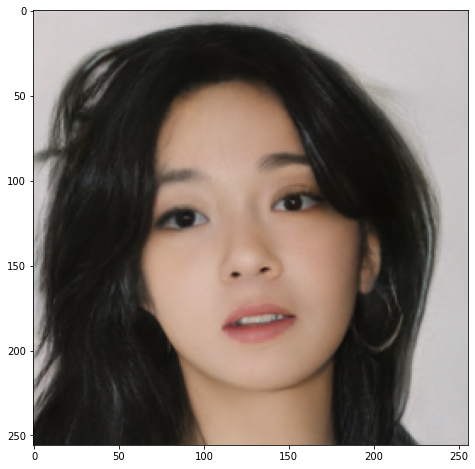

In [ ]:
img_gen, _ = g_ema(style2list(latent_path[-1]))

plt.figure(figsize=(8, 8))
plt.imshow(make_image(img_gen)[0])

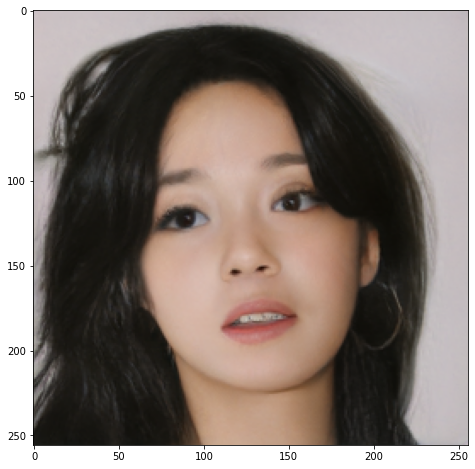

In [ ]:
img_gen, _ = g_ema(style2list(min_latent))

plt.figure(figsize=(8, 8))
plt.imshow(make_image(img_gen)[0])

In [ ]:
torch.save({'latent': min_latent}, '/content/drive/MyDrive/OpenSW/KSJ.pt')